# Regressão: Implemente uma rede neural com numpy
## Objetivos
* Aprenda conceitos de machine learning em detalhe.
* Construa e treine um modelo com a biblioteca numpy.
* Aprenda a usar uma rede neural para estimativa de valores.
* Veja um exemplo de problema do dia a dia que pode ser resolvido com regressão.
* Entenda por trás dos panos como é o aprendizado de máquina para regressão.

link: https://cursos.alura.com.br/course/rede-neural-numpy

## Importando as bibliotecas necessárias

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Carregando os dados e explorando eles

In [62]:
df = pd.read_csv("https://raw.githubusercontent.com/alura-cursos/redes-neurais/master/Bicicletas.csv")
df.head()

,clima,temperatura,bicicletas_alugadas
0,2,0.363625,985
1,2,0.353739,801
2,1,0.189405,1349
3,1,0.212122,1562
4,1,0.229270,1600


In [63]:
print(f'Esses dados são formados por {df.shape[0]} observações e {df.shape[1]} atributos')

Esses dados são formados por 731 observações e 3 atributos


In [64]:
df.describe()

,clima,temperatura,bicicletas_alugadas
count,731.000000,731.000000,731.000000
mean,1.395349,0.474354,4504.348837
std,0.544894,0.162961,1937.211452
min,1.000000,0.079070,22.000000
25%,1.000000,0.337842,3152.000000
50%,1.000000,0.486733,4548.000000
75%,2.000000,0.608602,5956.000000
max,3.000000,0.840896,8714.000000


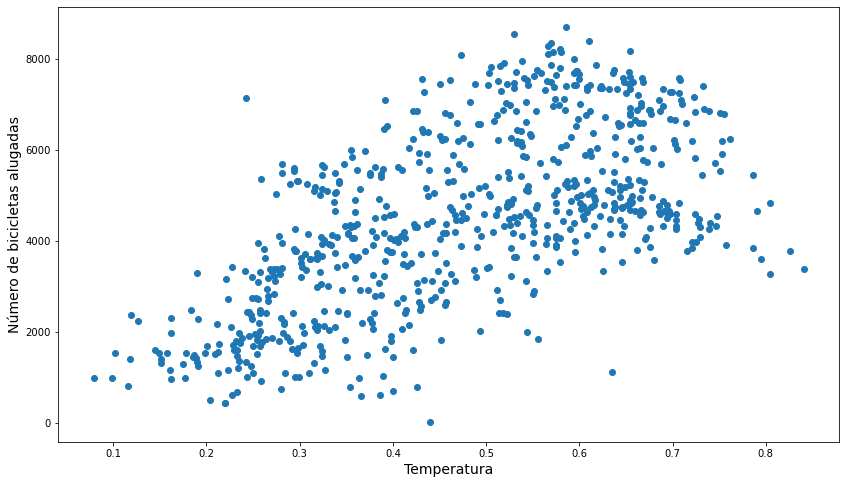

In [65]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(df['temperatura'], df['bicicletas_alugadas'])
ax.set_xlabel('Temperatura', fontsize=14)
ax.set_ylabel('Número de bicicletas alugadas', fontsize=14)
plt.show()

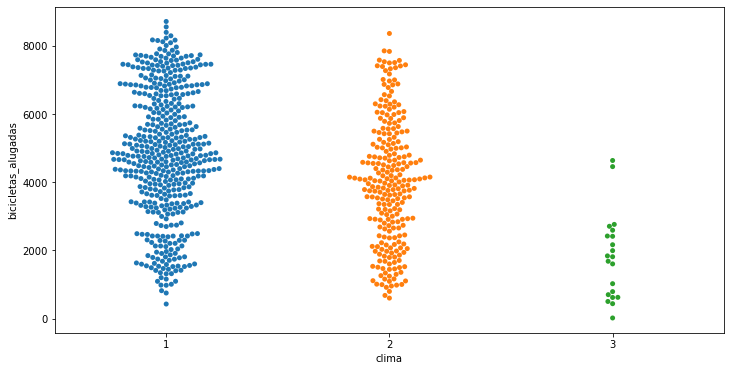

In [66]:
fig, ax = plt.subplots(figsize=(12,6))
sns.swarmplot(x='clima', y='bicicletas_alugadas', data=df, ax=ax)
plt.show()

In [67]:
y = df['bicicletas_alugadas'].values
X = df.drop(labels=['bicicletas_alugadas'], axis=1).values

In [68]:
ymax = np.amax(y)
ymax

8714

In [69]:
y = y/ymax

## Funções de ativação

In [130]:
def sigmoid(soma):
    return 1/(1+np.exp(-soma))

def relu(soma):
    return np.maximum(0, soma)

## Estrutura da rede

In [353]:
arquitetura = [
    {'dim_entrada': 2, 'dim_saida': 3, 'ativacao':relu},
    {'dim_entrada': 3, 'dim_saida': 1, 'ativacao':sigmoid}
]

## Inicializando a rede com pesos e vies

In [372]:
def inicia_camadas(arquitetura, seed=99):
    np.random.seed(seed)
    
    numero_de_camadas = len(arquitetura)
    
    valores_parametros = {}
    
    for indice, camada in enumerate(arquitetura):
        indice_camada = indice + 1
        
        tamanho_camada_entrada = camada['dim_entrada']
        tamanho_camada_saida = camada['dim_saida']
        
        valores_parametros['P' + str(indice_camada)] = np.random.randn(tamanho_camada_saida, tamanho_camada_entrada)
        valores_parametros['b' + str(indice_camada)] = np.random.randn(tamanho_camada_saida, 1)
        
    return valores_parametros

## Propagando os dados pela rede

In [373]:
def propaga_uma_camada(ativado_anterior, peso_atual, b_atual, ativacao):
    
    saida_atual = np.dot(peso_atual, ativado_anterior) + b_atual
    
    return ativacao(saida_atual), saida_atual

In [374]:
def propaga_total(X, valores_parametros, arquitetura):
    memoria = {}
    ativado_atual = X
    
    for indice, camada in enumerate(arquitetura):
        indice_camada = indice + 1
        ativado_anterior = ativado_atual
        func = camada['ativacao']
        
        peso_atual = valores_parametros['P' + str(indice_camada)]
        b_atual = valores_parametros['b' + str(indice_camada)]
        
        ativado_atual, saida_atual = propaga_uma_camada(ativado_anterior, peso_atual, b_atual, func)
        
        memoria['A' + str(indice)] = ativado_anterior
        memoria['Z' + str(indice_camada)] = saida_atual
        
    return ativado_atual, memoria

## Testando a rede

In [284]:
valores_parametros = inicia_camadas(arquitetura)

y_estimado, memoria = propaga_total(X.T, valores_parametros, arquitetura)

In [285]:
y_estimado[0,:10]

array([0.04011373, 0.04209807, 0.07060039, 0.06337533, 0.05838442,
       0.05729119, 0.08419077, 0.10438255, 0.09934532, 0.08460796])

## Função custo

In [407]:
def valor_de_custo(y_pred, y):
    m = y_pred.shape[1]
    
    custo = -1/m * (np.dot(y, np.log(y_pred).T)) + np.dot(1-y, np.log(1-y_pred).T)
    return np.squeeze(custo)

In [287]:
valor_de_custo(y_estimado, y)

array(-10.32474799)

## Atualiza os pesos

In [375]:
def atualiza(valores_parametros, gradientes, arquitetura, taxa_aprendizagem):
    
    for indice_camada, camada in enumerate(arquitetura, 1):
        valores_parametros['P' + str(indice_camada)] -= taxa_aprendizagem * gradientes['dP' + str(indice_camada)]
        valores_parametros['b' + str(indice_camada)] -= taxa_aprendizagem * gradientes['db' + str(indice_camada)]
        
    return valores_parametros

## Retropropagação

In [376]:
def retropropagacao_total(y_pred, y, memoria, valores_parametros, arquitetura):
    gradientes = {}
    
    # para garantir que os dois vetores tenham a mesma dimensão
    y = y.reshape(y_pred.shape)
    
    # inicia o algoritmo de gradiente descendente
    dAtivado_anterior = -(np.divide(y, y_pred) - np.divide(1-y, 1-y_pred))
    
    for indice_camada_anterior, camada in reversed(list(enumerate(arquitetura))):
        indice_camada_atual = indice_camada_anterior + 1
        funcao_ativacao_atual = camada['ativacao']
        
        dAtivado_atual = dAtivado_anterior
        
        # Função de ativação para a camada atual
        ativado_anterior = memoria['A' + str(indice_camada_anterior)]
        saida_atual = memoria['Z' + str(indice_camada_atual)]
        
        peso_atual = valores_parametros['P' + str(indice_camada_atual)]
        b_atual = valores_parametros['b' + str(indice_camada_atual)]
        
        dAtivado_anterior, dPesos_atual, db_atual = retropropagacao_uma_camada(
        dAtivado_atual, peso_atual, b_atual, saida_atual, ativado_anterior, funcao_ativacao_atual)
        
        gradientes['dP' + str(indice_camada_atual)] = dPesos_atual
        gradientes['db' + str(indice_camada_atual)] = db_atual
        
    return gradientes

In [377]:
def sigmoid_retro(dAtivado, saida):
    sig = sigmoid(saida)
    return dAtivado * sig * (1 - sig)

def relu_retro(dAtivado, saida):
    dSaida = np.array(dAtivado, copy=True)
    dSaida[saida <= 0] = 0
    return dSaida

In [378]:
def retropropagacao_uma_camada(dAtivado_atual, pesos_atual, b_atual, saida_atual,
                              ativado_anterior, ativacao):
    
    m = ativado_anterior.shape[1]
    
    if ativacao == relu:
        func_ativacao_retro = relu_retro
    elif ativacao == sigmoid:
        func_ativacao_retro = sigmoid_retro
    else:
        raise Exception('Ainda não implementamos essa')
    
    # derivada da função de ativação
    dSaida_atual = func_ativacao_retro(dAtivado_atual, saida_atual)
    # derivada da matriz de Pesos
    dPesos_atual = np.dot(dSaida_atual, ativado_anterior.T) / m
    # derivada do vetor b
    db_atual = np.sum(dSaida_atual, axis=1, keepdims=True) / m
    # derivada da matriz A_anterior
    dAtivado_anterior = np.dot(pesos_atual.T, dSaida_atual)
    
    return dAtivado_anterior, dPesos_atual, db_atual

In [409]:
def treino(X, y, X_test, y_test, arquitetura, epochs, taxa_aprendizagem):
    valores_parametros = inicia_camadas(arquitetura, 2)
    
    historia_custo = []
    historia_custo_test = []
    
    for i in range(epochs):
        y_pred, memoria = propaga_total(X, valores_parametros, arquitetura)
        
        y_pred_test, memoria2 = propaga_total(X_test, valores_parametros, arquitetura)
        
        # calcula as métricas e salva nas listas de história
        custo = valor_de_custo(y_pred, y)
        historia_custo.append(custo)
        custo_teste = valor_de_custo(y_pred_test, y_test)
        historia_custo_teste.append(custo_teste)
        
        gradientes = retropropagacao_total(y_pred, y, memoria, valores_parametros, arquitetura)
        
        # Atualiza os pesos
        valores_parametros = atualiza(valores_parametros, gradientes, arquitetura, taxa_aprendizagem)
        
        if (i % 5000 == 0):
             print(f'Iteração {i:05} - custo {custo:0.5f}')
        
    return valores_parametros, historia_custo, historia_custo_teste

## Treinamento

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.43, random_state=43)

valores_parametros, historia_custo, historia_custo_tesate = treino(X_train.T, np.transpose(y_train.reshape((y_train.shape[0], 1))), 
                                                                  X_test.T, np.transpose(y_test.reshape((y_test.shape[0], 1))), 
                                                                  arquitetura, 10000, 0.01)

Iteração 00000 - custo -141.76619
Iteração 05000 - custo -143.68500


## Mostrando visualmente a evolução do custo

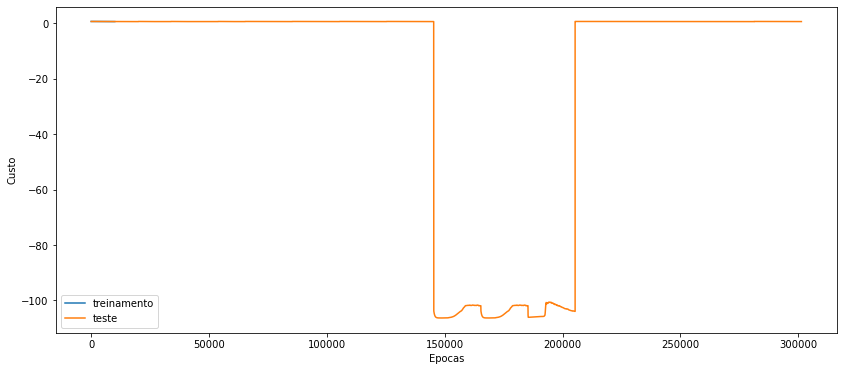

In [405]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(historia_custo)
ax.plot(historia_custo_teste)
ax.legend(['treinamento', 'teste'])
ax.set_xlabel('Epocas')
ax.set_ylabel('Custo')

plt.show()

In [397]:
len(historia_custo_teste)

291300